In [1]:
"""
In this script, we will

Apply inference with our current script
Apply Tracking with sort.py or strong_sort(if possible)
"""

import torch 
from os import listdir
import pandas as pd
from sort import sort
import cv2
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict

model = torch.hub.load('.','custom','best.pt',source='local')


path = "data/localization/test/"
images = listdir(path+"images/")
images = [path+"images/"+image for image in images]
videos = listdir(path+"videos/")
videos = [path+"videos/"+video for video in videos]
#print(videos)

/home/erick/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
YOLOv5 🚀 163666e80 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 212 layers, 20893344 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
model.conf = .4 #Play with minimum

Traffic detected(Vehicles & Pedestrians): 2


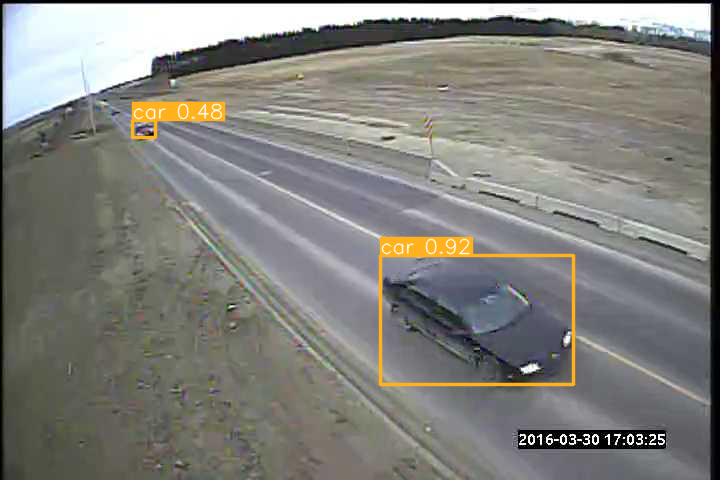

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


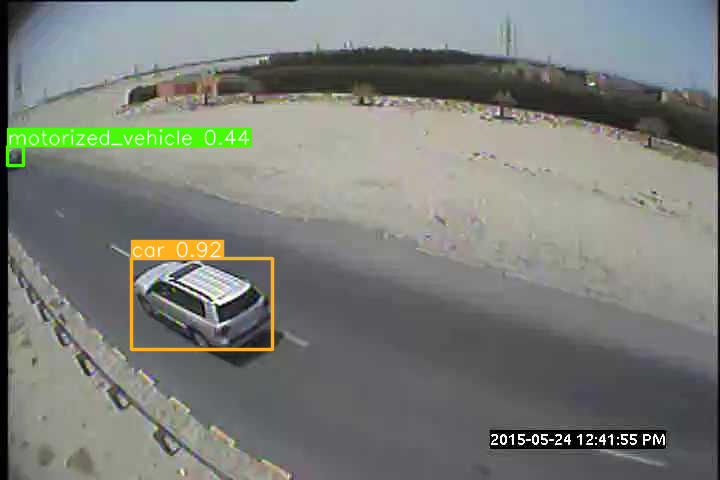

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


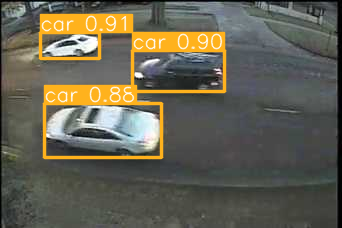

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


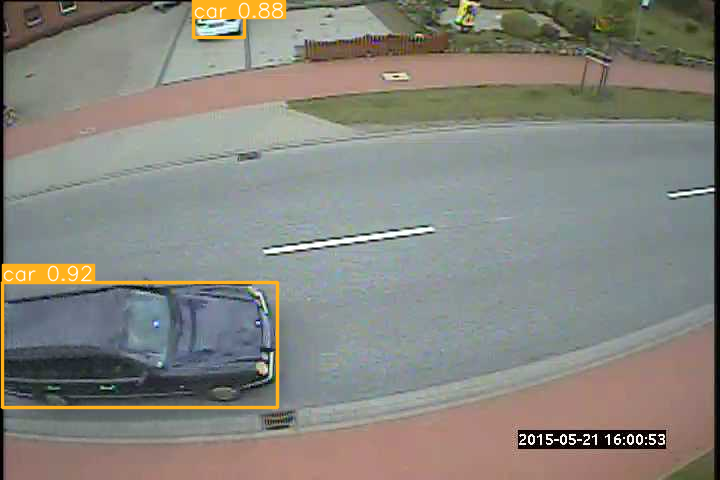

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


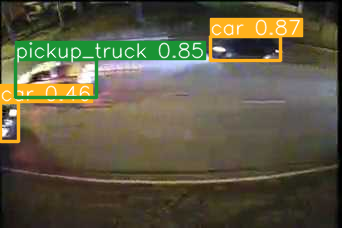

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 5


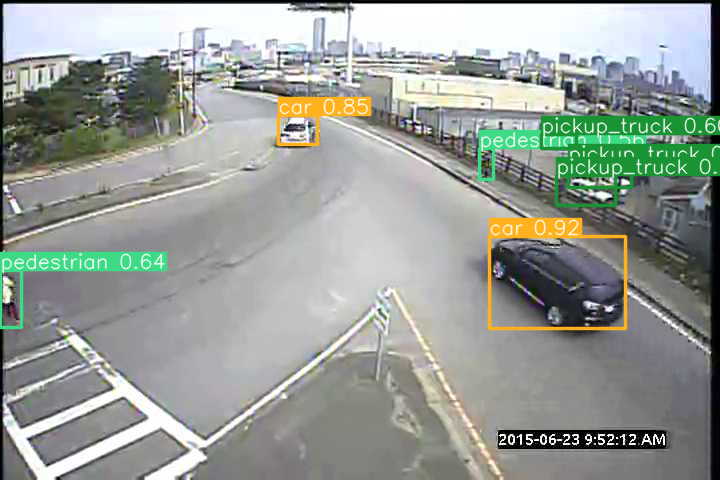

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 5


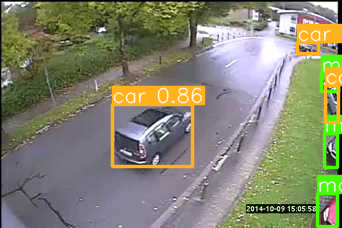

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


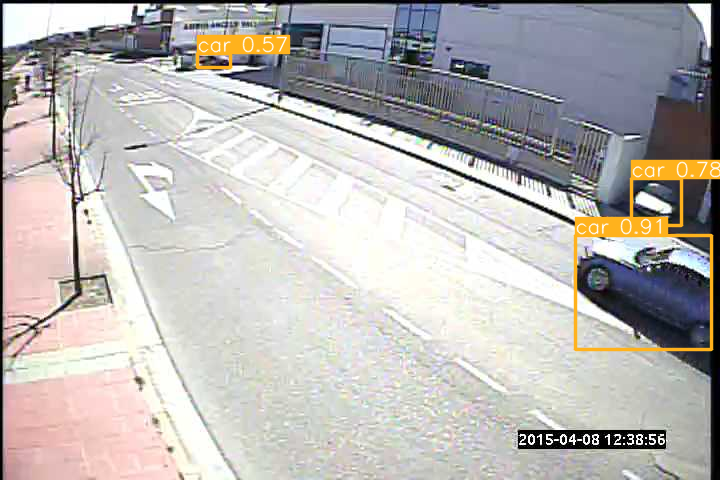

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 2


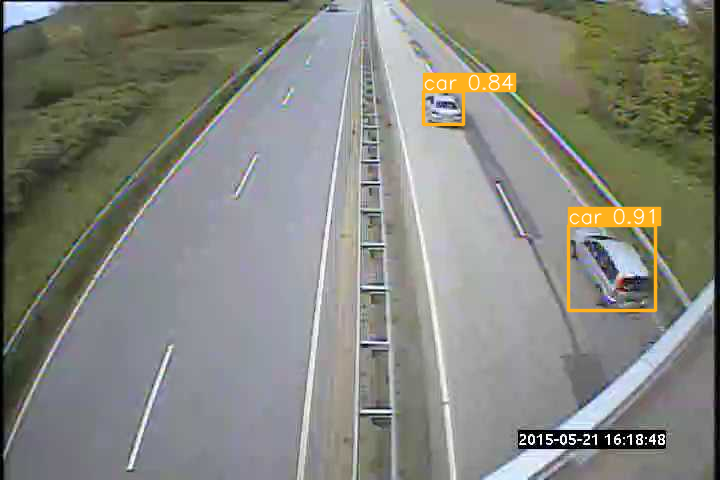

Saved 1 image to runs/detect/image_run


Traffic detected(Vehicles & Pedestrians): 3


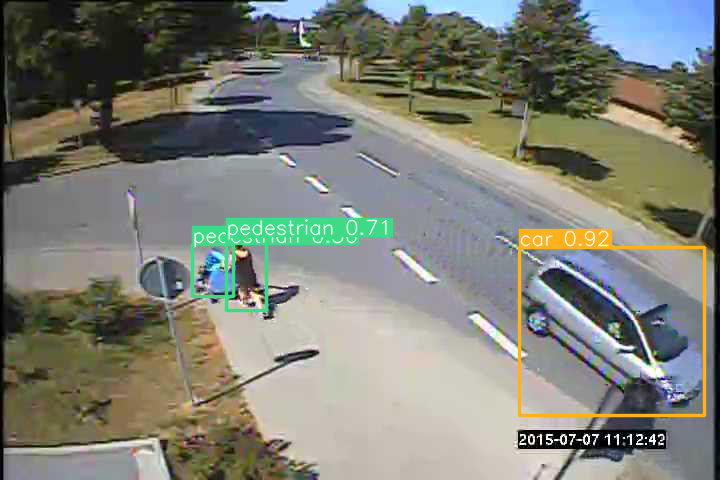

Saved 1 image to runs/detect/image_run


[2, 2, 3, 2, 3, 5, 5, 3, 2, 3]


In [3]:
"""
Count number of cars per image
"""
count_list = []
limit = 0
for image in images:
    if limit == 10:
        break
    count = 0
    ids = set()
    results = model(image)
    #results.show()
    #Retrieving boundingbox data as dataframe 
    #Dataframe Format (xyxy attribute):
    #(xmin,ymin,xmax,ymax,confidence,label_value,label)
    df = results.pandas().xyxy[0]
    data = df.iloc[:][:5].to_numpy()
    data = data[:,:5]
    
    tracker=sort.Sort()
    track_res = tracker.update(data)
    for vehicle in track_res[:,4]:
        if vehicle not in ids:
            ids.add(vehicle)
            count += 1
        
    #Save within the same folder
    print("Traffic detected(Vehicles & Pedestrians):",count)
    results.show()#Use this line if you have a limit
    results.save(save_dir='runs/detect/image_run',
                 exist_ok=True)
    count_list.append(count)
    limit += 1

print(count_list)

In [ ]:
count_list = []
vid_count = 1
myFont = ImageFont.truetype('Oswald-Bold.ttf', 20)#Text font

for video in videos:
    print("Currently processing video ",vid_count)
    vid = cv2.VideoCapture(video)
    ret,frame = vid.read()
    image_frames = []
    
    #Store tracking info per video
    tracker=sort.Sort() 
    ids = defaultdict(set)
    count = 0
    while(ret):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
        results = model(frame)
        
        #Retrieving boundingbox data as dataframe 
        #Dataframe Format (xyxy attribute):
        #(xmin,ymin,xmax,ymax,confidence,label_value,label)
        data = results.pandas().xyxy[0]
        trafficType=data["name"]
        data = data.iloc[:][:5].to_numpy()
        data = data[:,:5].astype('float64')
        #Updated with ids on the camera
        #ROW_LENGTH=Number of vehicles detected
        track_res = tracker.update(data)
        
        if(track_res.size!=0):
            for index,detection in enumerate(track_res[::-1]):
                #If the detection is new, add the ID to the
                #appropriate vehicle/pedestrian set
                #COUNT=LENGTH
                if(detection[-1] not in ids[trafficType[index]]):
                    ids[trafficType[index]].add(detection[-1])
        
        #Image WITH BOX PREDICTIONS AND COUNT
        im = Image.fromarray(results.render(labels=False)[0])
        im_draw = ImageDraw.Draw(im)
        draw_text=""
        for trafficType, id_set in ids.items():
            draw_text+=trafficType.upper()+" COUNT=" +str(len(id_set))+"\n"

        im_draw.multiline_text((0,
                          0), 
                     draw_text,
                     fill='white',font=myFont,
                     anchor = None, spacing = 0,
                     align="left",direction=None,
                     features=None,language=None,
                     stroke_width=1, stroke_fill="black")
        
        #Check if the images are being properly converted:
        #im.show()
        image_frames.append(im)#Append for conversion to video
        ret, frame = vid.read()
        #length -=1
    if(len(image_frames)>0):
        #Save video as gif
        image_frames[0].save('runs/detect/videos/video'+str(vid_count)+".gif",
                         save_all=True, optimize=False,append_images=image_frames[1:],loop=0)
    else:
        print("No image frames to save!")
    vid_count+=1
    
    
print("Final Count list:", [len(x) for x in ids])

Currently processing video  1
Currently processing video  2
Currently processing video  3
Currently processing video  4
Currently processing video  5
Currently processing video  6
Currently processing video  7
Currently processing video  8
Currently processing video  9
Currently processing video  10
Currently processing video  11
Currently processing video  12
Currently processing video  13
Currently processing video  14
Currently processing video  15
Currently processing video  16
Currently processing video  17
Currently processing video  18
